# Experiment

## Install Python dependencies

Import the dependencies for the model training code:

In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

## Load the CSV data

The CSV data that you use to train the model contains the following fields:

* **distancefromhome** - The distance from home where the transaction happened.
* **distancefromlast_transaction** - The distance from the last transaction that happened.
* **ratiotomedianpurchaseprice** - The ratio of purchased price compared to median purchase price.
* **repeat_retailer** - If it's from a retailer that already has been purchased from before.
* **used_chip** - If the credit card chip was used.
* **usedpinnumber** - If the PIN number was used.
* **online_order** - If it was an online order.
* **fraud** - If the transaction is fraudulent.

In [2]:
Data = pd.read_csv('data/card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
import torch

# Set the input (X) and output (Y) data. 
# The only output data is whether it's fraudulent. All other fields are inputs to the model.

X = torch.tensor(Data.drop(columns = ['repeat_retailer','distance_from_home', 'fraud']).values, dtype=torch.float)
y = torch.tensor((Data['fraud']).values, dtype=torch.float)

# Split the data into training and testing sets so you have something to test the trained model with.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.
scaler = StandardScaler()

X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float)
X_val = torch.tensor(scaler.transform(X_val), dtype=torch.float)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), set a pos_weight to weight the few fraudulent transactions higher than the many non-fraud transactions.
positives = torch.sum(y_train)
negatives = (len(y_train) - torch.sum(y_train))
pos_weight = torch.unsqueeze((negatives / positives), 0)


## Build the model

The model is a simple, fully-connected, deep neural network, containing three hidden layers and one output layer.

In [4]:
import torch

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

device

'cpu'

In [5]:
import torch
from torch import nn, optim

model = nn.Sequential(
    nn.Linear(in_features=X.shape[1], out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=4),
    nn.ReLU(),
    nn.Linear(in_features=4, out_features=1),
    nn.Sigmoid(),
).to(device)

model

Sequential(
  (0): Linear(in_features=5, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [6]:
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
optimizer = optim.Adam(params=model.parameters(), lr=0.01)


def accuracy_fn(y_pred, y_actual):
    correct = torch.eq(torch.round(y_pred), y_actual).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Train the model

Training a model is often the most time-consuming part of the machine learning process.  Large models can take multiple GPUs for days.  Expect the training on CPU for this very simple model to take a minute or more.

In [7]:
torch.manual_seed(0) #manually seeding for reproducibility

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    # Training
    model.train()

    y_pred = model(X_train).squeeze()
    loss = loss_fn(y_pred, y_train)
    acc = accuracy_fn(y_pred, y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Validate
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val).squeeze()
        val_loss = loss_fn(y_pred, y_val)
        val_acc = accuracy_fn(y_pred, y_val)

    if epoch % (epochs // 10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | "
              f"Validation loss: {val_loss:.5f}, Val acc: {val_acc:.2f}%")


print(f"Final Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | "
      f"Test loss: {val_loss:.5f}, Test acc: {val_acc:.2f}%")

Epoch: 0 | Loss: 1.35462, Accuracy: 8.74% | Validation loss: 1.35215, Val acc: 8.74%
Epoch: 100 | Loss: 1.01747, Accuracy: 94.73% | Validation loss: 1.01823, Val acc: 94.70%
Epoch: 200 | Loss: 1.01164, Accuracy: 95.10% | Validation loss: 1.01223, Val acc: 95.05%
Epoch: 300 | Loss: 1.00966, Accuracy: 95.25% | Validation loss: 1.01016, Val acc: 95.22%
Epoch: 400 | Loss: 1.00857, Accuracy: 95.35% | Validation loss: 1.00903, Val acc: 95.33%
Epoch: 500 | Loss: 1.00794, Accuracy: 95.39% | Validation loss: 1.00836, Val acc: 95.38%
Epoch: 600 | Loss: 1.00753, Accuracy: 95.44% | Validation loss: 1.00795, Val acc: 95.42%
Epoch: 700 | Loss: 1.00725, Accuracy: 95.45% | Validation loss: 1.00765, Val acc: 95.43%
Epoch: 800 | Loss: 1.00703, Accuracy: 95.46% | Validation loss: 1.00740, Val acc: 95.45%
Epoch: 900 | Loss: 1.00685, Accuracy: 95.47% | Validation loss: 1.00720, Val acc: 95.47%
Final Epoch: 999 | Loss: 1.00670, Accuracy: 95.49% | Test loss: 1.00708, Test acc: 95.49%


## Test the Model

In [8]:
def run_inference(data):
    scaled_tx = torch.tensor(scaler.transform(data).astype(np.float32),
                             dtype=torch.float)
    scaled_tx

    model.eval()
    with torch.inference_mode():
        prediction = torch.round(model(scaled_tx))

    if prediction.item() == 1:
        return "fraud"
    else:
        return "NOT fraud"

In [9]:
# valid transaction
valid_tx = [[0.0, 1.0, 1.0, 1.0, 0.0]]
prediction = run_inference(valid_tx)
print(f"The model thinks the valid transaction is {prediction}")

The model thinks the valid transaction is NOT fraud


In [10]:
# fraudulent use case
fraud_tx = [[100, 1.2, 0.0, 0.0, 1.0]]
prediction = run_inference(fraud_tx)
print(f"The model thinks the valid transaction is {prediction}")

The model thinks the valid transaction is fraud


In [11]:
### Testing
model.eval()
with torch.inference_mode():
    y_pred = model(X_test).squeeze()
    acc = accuracy_fn(y_pred, y_test)

Accuracy: 95.4265


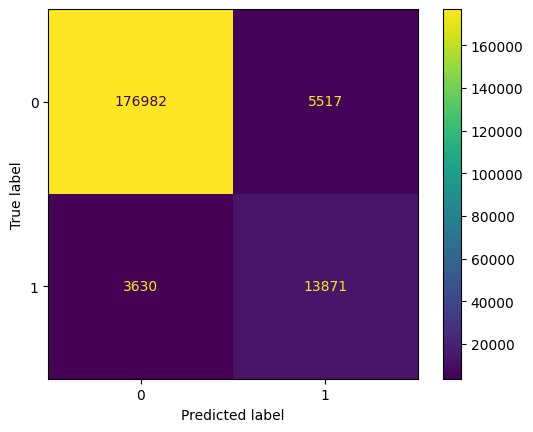

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

print(f"Accuracy: {acc}")

c_matrix = confusion_matrix(y_test, torch.round(y_pred))
ConfusionMatrixDisplay(c_matrix).plot()


## Save the model file

In [13]:
!pip install onnx onnxscript onnxruntime


[notice] A new release of pip available: 22.2.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [14]:
!pip install -U onnx onnxscript 


[notice] A new release of pip available: 22.2.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [15]:
model

Sequential(
  (0): Linear(in_features=5, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [16]:
import os

os.makedirs("models/fraud/1", exist_ok=True)
dummy_input = torch.randn(1, 5, device=device)
torch.onnx.export(model,
                  dummy_input,
                  "models/fraud/1/model.onnx",
                  input_names=["inputs"],
                  output_names=["outputs"],
                  dynamic_axes={
                      "inputs": {0: "batch_size"},
                  },
                  verbose=True)

Exported graph: graph(%inputs : Float(*, 5, strides=[5, 1], requires_grad=0, device=cpu),
      %0.weight : Float(8, 5, strides=[5, 1], requires_grad=1, device=cpu),
      %0.bias : Float(8, strides=[1], requires_grad=1, device=cpu),
      %2.weight : Float(4, 8, strides=[8, 1], requires_grad=1, device=cpu),
      %2.bias : Float(4, strides=[1], requires_grad=1, device=cpu),
      %4.weight : Float(1, 4, strides=[4, 1], requires_grad=1, device=cpu),
      %4.bias : Float(1, strides=[1], requires_grad=1, device=cpu)):
  %/0/Gemm_output_0 : Float(*, 8, strides=[8, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/0/Gemm"](%inputs, %0.weight, %0.bias), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.linear.Linear::0 # /opt/app-root/lib64/python3.9/site-packages/torch/nn/modules/linear.py:116:0
  %/1/Relu_output_0 : Float(*, 8, strides=[8, 1], requires_grad=1, device=cpu) = onnx::Relu[onnx_name="/1/Relu"](%/0/Gemm_output_0), scope: torch

In [17]:
# import os

# os.makedirs("models/fraud/1", exist_ok=True)
# dummy_input = torch.randn(1, 5, device=device)
# onnx_model = torch.onnx.dynamo_export(model, dummy_input)
# onnx_model.save("models/fraud/1/model.onnx")

## Confirm the model file was created successfully

The output should include the model name, size, and date. 

In [18]:
!ls -alRh ./models/fraud/1/model.onnx

-rw-r--r--. 1 1001170000 1001170000 22K Jul  2 14:37 ./models/fraud/1/model.onnx


In [19]:
import os

file_path = './models/fraud/1/model.onnx'  # Replace with the actual file path
if os.path.isfile(file_path):
    print(f"Exported model file exists at {file_path}")
else:
    raise FileNotFoundError(f"Expected model file at {file_path} missing")

Exported model file exists at ./models/fraud/1/model.onnx


## Test the model

In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt

import onnx
import onnxruntime as rt

Create an ONNX inference runtime session and predict values for all test inputs:

In [21]:
onnx_test_data = scaler.transform(X_test).astype(np.float32).tolist()
sess = rt.InferenceSession("models/fraud/1/model.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred = torch.tensor(sess.run([output_name], {input_name: onnx_test_data})[0])
y_pred

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

Show the results:

In [22]:
torch.where(y_pred > 0)

(tensor([    14,     42,     64,  ..., 199908, 199939, 199949]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

Accuracy: 95.4265


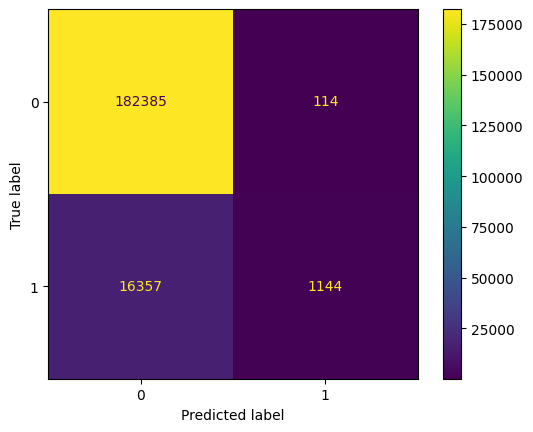

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

print(f"Accuracy: {acc}")

c_matrix = confusion_matrix(y_test, torch.round(y_pred))
ConfusionMatrixDisplay(c_matrix).plot()

## Example: Is Sally's transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
* distance_from_last_transaction
* ratio_to_median_price
* used_chip 
* used_pin_number
* online_order 

In [24]:
sally_transaction_details = [
    [0.3111400080477545,
    1.9459399775518593, 
    1.0, 
    0.0, 
    0.0]
    ]

scaled_tx = torch.tensor(scaler.transform(sally_transaction_details).astype(np.float32),
                         dtype=torch.float)
prediction = sess.run([output_name], {input_name: scaler.transform(scaled_tx).astype(np.float32)})

print("Is Sally's transaction predicted to be fraudulent?")

if round(prediction[0].item()) == 1:
    print("The model predicts this is fraud")
else:
    print("The model predicts this is NOT fraud")

Is Sally's transaction predicted to be fraudulent?
The model predicts this is NOT fraud
